# Ideas

More options:

- Agents have a chance to step out of the market (renting for example)
- Salary scales with other values than inflation
- Agents who already have a house have a chance of of selling and a chance of buying a new house
- Real location based on distance in a grid
- Seller price is based on the features of the house
- Multiple buyers fight for 1 house per time step
- When selling a house, chance to become a buyer
- Somehow implementing the idea of renting
- Chance to buy multiple houses
- Tweeverdieners
- Andere verdeling huizengroottes
- Overbieden
- Extra buyers and sellers based on data
- Faster
- Niet voor elke buyer elke seller bekijken
- Kans om niet meer samen te wonen
- Verschil tussen starters, ouderen en anderen

Possible options:

- Budget and willingness to pay is based on factors like age and family size instead of random
- Agents are able to save money (increase budget) when not buying a house
- Agents are more or less sensitive to changes in interest rates
- Different agents can get different loans (credit score)
- Demographic changes
- Market shocks (crisissituaties en hoe het model zal reageren)
- Cities where multiple houses in small space on grid

More visualizations:

- Data on x-axis instead of month number
- Heatmaps of houses across regions
- Scenario analysis (run one agent and see what happens)
- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Histogram of house prices per time step (interactive?)
- Interactive dashboard to run one agent at the time?

## Imports

In [41]:
import mesa
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

In [42]:
# data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
# the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df_interest = pd.read_csv('data_interest_rate.csv')
df_interest.drop([df_interest.index[120]], inplace=True)
df_interest.rename(columns={'Index': 'date'}, inplace=True)
display(df_interest.head())

df_inflation = pd.read_csv('inflation_data.csv')
df_inflation.drop([df_inflation.index[120]], inplace=True)
df_inflation.rename(columns={'observation_date': 'date',
                             'T10YIE': 'inflation_rate'}, inplace=True)
display(df_inflation.head())

,date,interest_rate
0,01/01/2013,0.084401
1,01/02/2013,0.172100
2,01/03/2013,0.050341
3,01/04/2013,-0.024212
4,01/05/2013,-0.019391


,date,inflation_rate
0,01/01/2013,2.52
1,01/02/2013,2.55
2,01/03/2013,2.54
3,01/04/2013,2.41
4,01/05/2013,2.28


## Classes

House in suburban sold to buyer aged 46.083333333333336 for 4141900.7208264307
House in suburban sold to buyer aged 46.083333333333336 for 4141900.7208264307
House in rural sold to buyer aged 28.083333333333332 for 4841605.731263439
House in suburban sold to buyer aged 46.16666666666667 for 4141900.7208264307
House in urban sold to buyer aged 24.249999999999996 for 4932156.017822499
House in rural sold to buyer aged 28.33333333333333 for 4841605.731263439
House in urban sold to buyer aged 24.499999999999993 for 4932156.017822499
House in suburban sold to buyer aged 46.58333333333335 for 4141900.7208264307
House in rural sold to buyer aged 28.666666666666657 for 4841605.731263439


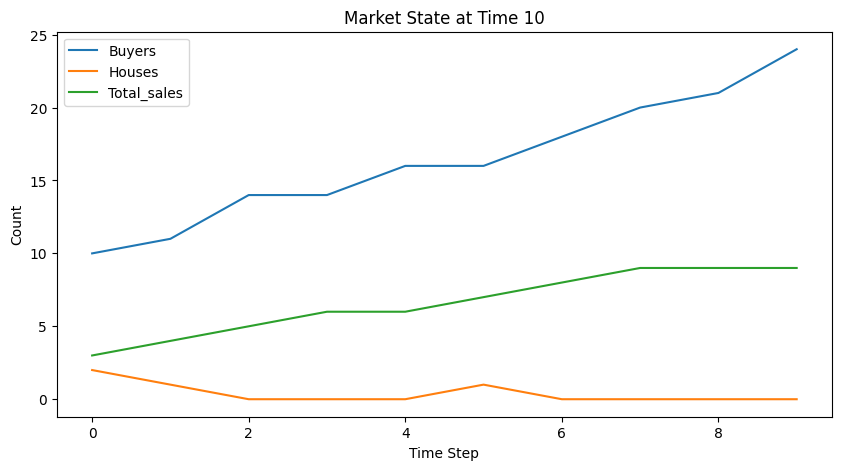

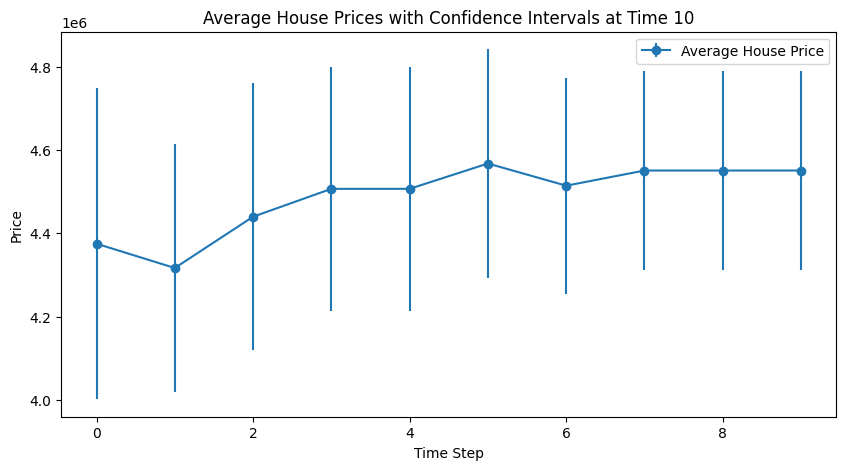

In [43]:
INTEREST_RATE_MONTHLY = 0.045 / 12

class Buyer(mesa.Agent):
    def __init__(self, model, salary: float, savings: float, age: float, dual_income: bool, prefered_location: str):
        super().__init__(model)
        self.salary = salary * 1.5 if dual_income else salary # assume dual_income increases salary by 50%
        self.savings = savings
        self.age = age
        self.dual_income = dual_income
        self.prefered_location = prefered_location
        self.budget = self.calculate_budget()
        
    def calculate_budget(self):
        willing_to_pay_percentage = 0.35 - (0.10 * (self.age - 20) / 40) # use age as a indicator of how much willing to pay
        
        payments = 360 # assume a 30 year morgage: 12 months * 30 years = 360
    
        M = self.salary * willing_to_pay_percentage
        return (M * ((1 + INTEREST_RATE_MONTHLY)**payments - 1)) / (INTEREST_RATE_MONTHLY * (1 + INTEREST_RATE_MONTHLY)**payments)

class House(mesa.Agent):
    def __init__(self, model, location: str, size: int):
        super().__init__(model)
        self.location = location
        self.size = size

class Market(mesa.Model):
    def __init__(self, num_buyers, num_houses):
        super().__init__()
        self.buyers = []
        self.houses = []
        self.sales = []
        self.time = 0
        self.buyer_counts = []
        self.house_counts = []
        self.sale_counts = []
        self.average_prices = []
        self.price_conf_intervals = []

        # Create initial buyers
        for i in range(num_buyers):
            self.add_buyer()

        # Create initial houses
        for i in range(num_houses):
            self.add_house()

    def add_buyer(self):
        mean_salary = 50_000 * 1.003 ** self.time # realistic value
        std_dev_salary = 1000 * 1.003 ** self.time # realistic value
        salary = np.clip(int(np.random.normal(mean_salary, std_dev_salary)), 20_000, 1_000_000)
        savings = self.random.uniform(0, 50_000) # add realistic savings
        age = self.random.randint(20, 60) # add realistic distribution
        dual_income = self.random.choice([True, False]) # add realistic distribution
        prefered_location = self.random.choice(["urban", "suburban", "rural"]) # add realistic chances
        buyer = Buyer(self, salary, savings, age, dual_income, prefered_location)
        self.buyers.append(buyer)
        self.agents.add(buyer)

    def add_house(self):
        location = self.random.choice(["urban", "suburban", "rural"])
        # The exact number does not matter, just relative to the other numbers
        size = self.random.randint(1, 10)
        house = House(self, location, size)
        self.houses.append(house)
        self.agents.add(house)
    
    def step(self):
        self.time += 1
        
        for i in range(random.randint(0, 3)): self.add_buyer() # add realistic chances
        for i in range (random.randint(0, 2)): self.add_house() # add realistic chances
        
        self.agents.shuffle_do('step')

        # Salaries increase slightly
        for buyer in self.buyers:
            buyer.salary *= 1.003  # add realistic number

        # Buyers age and save money
        for buyer in self.buyers:
            buyer.age += 1/12
            buyer.savings += buyer.budget * 0.1  # Assume 10% of monthly money is saved

        self.market_model()
                
        self.buyer_counts.append(len(self.buyers))
        self.house_counts.append(len(self.houses))
        self.sale_counts.append(len(self.sales))
        
        # Calculate average house price and confidence interval
        if self.sales:
            prices = [list(sale.values())[0].budget for sale in self.sales]
            avg_price = np.mean(prices)
            conf_interval = 1.96 * np.std(prices) / np.sqrt(len(prices))
            self.average_prices.append(avg_price)
            self.price_conf_intervals.append(conf_interval)
        else:
            self.average_prices.append(0)
            self.price_conf_intervals.append(0)
    
    def market_model(self):
        self.houses.sort(key=lambda h: h.size) # sell the biggest house first
        for house in self.houses:
            interested_buyers = [b for b in self.buyers if b.prefered_location == house.location]
            if interested_buyers:
                # Buyer with the highest budget gets the house
                winning_buyer = max(interested_buyers, key=lambda b: b.budget)
                self.houses.remove(house)
                self.sales.append({house: winning_buyer})
                print(f"House in {house.location} sold to buyer aged {winning_buyer.age} for {winning_buyer.budget}")
    
    def visualize(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.time), self.buyer_counts, label="Buyers")
        plt.plot(range(self.time), self.house_counts, label="Houses")
        plt.plot(range(self.time), self.sale_counts, label="Total_sales")
        plt.title(f"Market State at Time {self.time}")
        plt.xlabel("Time Step")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.errorbar(range(self.time), self.average_prices, yerr=self.price_conf_intervals, fmt='-o', label="Average House Price")
        plt.title(f"Average House Prices with Confidence Intervals at Time {self.time}")
        plt.xlabel("Time Step")
        plt.ylabel("Price")
        plt.legend()
        
# Initialize the market with 10 buyers and 5 houses
market = Market(num_buyers=10, num_houses=5)

# Run the model for 10 steps and visualize the market state at each step
for _ in range(10):
    market.step()

market.visualize()